In [1]:
import time
import json
import base64
import numpy as np
import boto3

runtime = boto3.client("sagemaker-runtime", region_name="us-east-1")

### Testing the coldstart duration for b32 model

In [2]:
# the endpoints
endpoint_name_pc = "normalized-b32-model"       # With provisioned concurrency
endpoint_name_on_demand = "normalized-b32-model-v2"  # Without provisioned concurrency

# Prepare the image payload
with open("aws_login.png", "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

input_data = {
    "inputs": {
        "image": encoded_image
    }
}

payload = json.dumps(input_data)

# Cold start testing
print("Testing cold start for serverless inference with PC vs no PC")
pc_times = []
non_pc_times = []

for i in range(5):
    print(f"Test round {i+1}...")

    # Sleep to simulate cold start
    time.sleep(600)  # 10 minutes

    # With provisioned concurrency
    start_pc = time.time()
    pc_response = runtime.invoke_endpoint(
        EndpointName=endpoint_name_pc,
        ContentType="application/json",
        Body=payload
    )
    pc_time = time.time() - start_pc
    pc_times.append(pc_time)
    print(f"PC round {i+1} took {pc_time:.2f} seconds")

    # Without provisioned concurrency
    start_no_pc = time.time()
    non_pc_response = runtime.invoke_endpoint(
        EndpointName=endpoint_name_on_demand,
        ContentType="application/json",
        Body=payload
    )
    no_pc_time = time.time() - start_no_pc
    non_pc_times.append(no_pc_time)
    print(f"No-PC round {i+1} took {no_pc_time:.2f} seconds")

# Results
pc_cold_start = np.mean(pc_times)
non_pc_cold_start = np.mean(non_pc_times)

print("\n✅ Results:")
print(f"Provisioned Concurrency Serverless Inference Average Cold Start: {pc_cold_start:.2f} seconds")
print(f"On Demand Serverless Inference Average Cold Start: {non_pc_cold_start:.2f} seconds")

Testing cold start for serverless inference with PC vs no PC
Test round 1...
PC round 1 took 3.01 seconds
No-PC round 1 took 27.64 seconds
Test round 2...
PC round 2 took 1.24 seconds
No-PC round 2 took 27.65 seconds
Test round 3...
PC round 3 took 2.05 seconds
No-PC round 3 took 22.56 seconds
Test round 4...
PC round 4 took 4.28 seconds
No-PC round 4 took 28.15 seconds
Test round 5...
PC round 5 took 3.69 seconds
No-PC round 5 took 22.40 seconds

✅ Results:
Provisioned Concurrency Serverless Inference Average Cold Start: 2.85 seconds
On Demand Serverless Inference Average Cold Start: 25.68 seconds


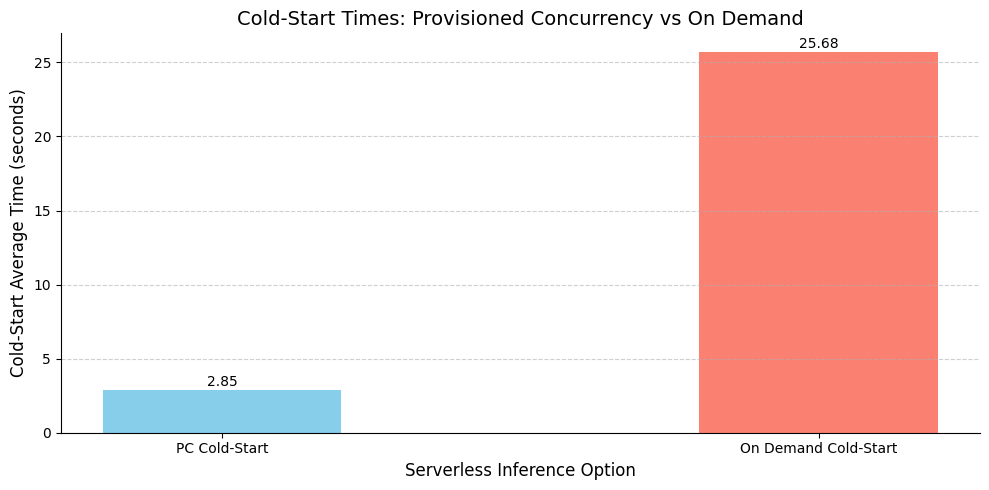

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the benchmarking
data = {'PC Cold-Start': pc_cold_start, 'On Demand Cold-Start': non_pc_cold_start}
cold_starts = list(data.keys())
values = list(data.values())

# Set up the figure and bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(cold_starts, values, color=['skyblue', 'salmon'], width=0.4)

# Adding numeric value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

# Adding titles and labels
plt.xlabel("Serverless Inference Option", fontsize=12)
plt.ylabel("Cold-Start Average Time (seconds)", fontsize=12)
plt.title("Cold-Start Times: Provisioned Concurrency vs On Demand", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()
